In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [3]:
train_path = "../data/KDDTrain+.txt"
test_path  = "../data/KDDTest+.txt"

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)

Training Data Shape:    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0

In [4]:
# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',
    
    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())

Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [5]:
#Definign feature Groups

categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(df_train.isnull())

Categorical Features: 3
Binary Features: 4
Numerical Features: 34
        duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0          False          False    False  False      False      False  False   
1          False          False    False  False      False      False  False   
2          False          False    False  False      False      False  False   
3          False          False    False  False      False      False  False   
4          False          False    False  False      False      False  False   
...          ...            ...      ...    ...        ...        ...    ...   
125968     False          False    False  False      False      False  False   
125969     False          False    False  False      False      False  False   
125970     False          False    False  False      False      False  False   
125971     False          False    False  False      False      False  False   
125972     False          False    False  False      F

In [6]:
def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)

Identifies 1256 Outlilers using the Isolation forest


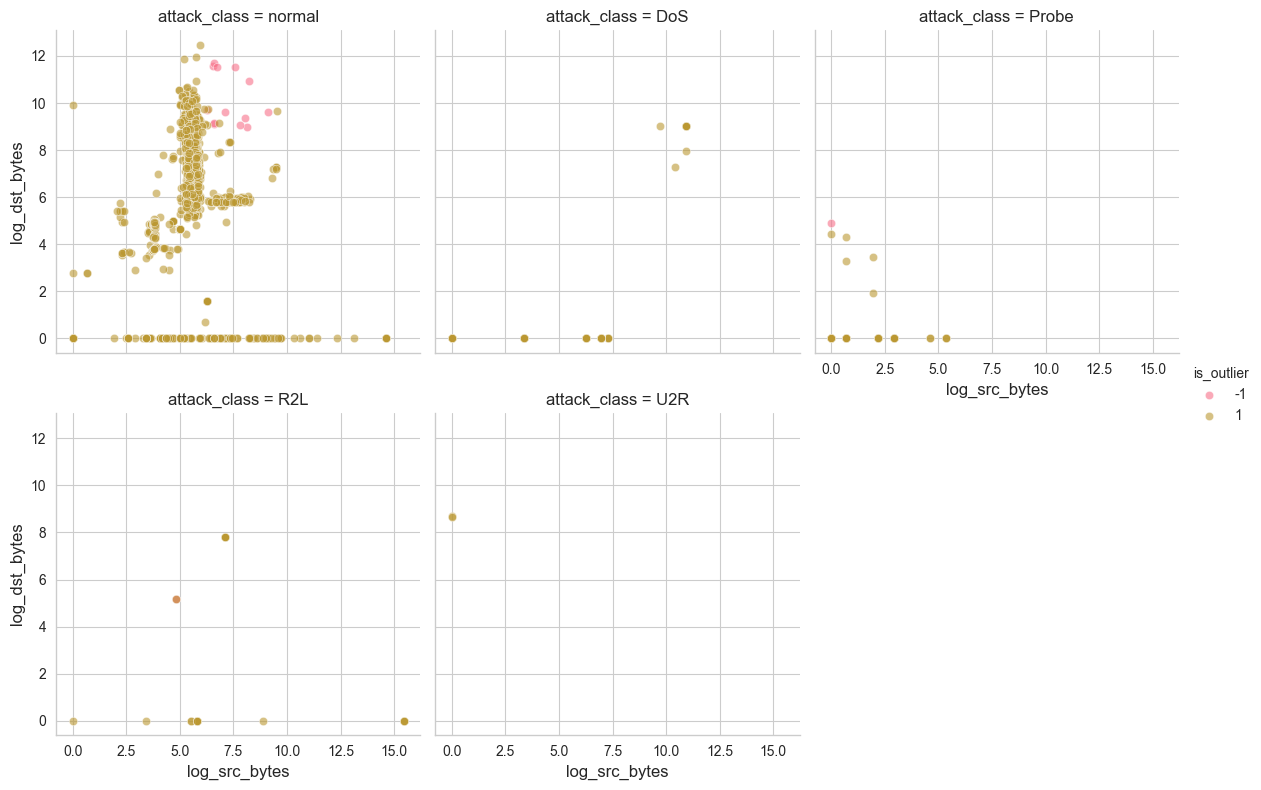

In [9]:
g = sns.FacetGrid(
    df_train.sample(3000, random_state=42),
    col="attack_class",
    hue="is_outlier",
    col_wrap=3,
    height=4
)

g.map(sns.scatterplot, "log_src_bytes", "log_dst_bytes", alpha=0.6)
g.add_legend()

plt.show()

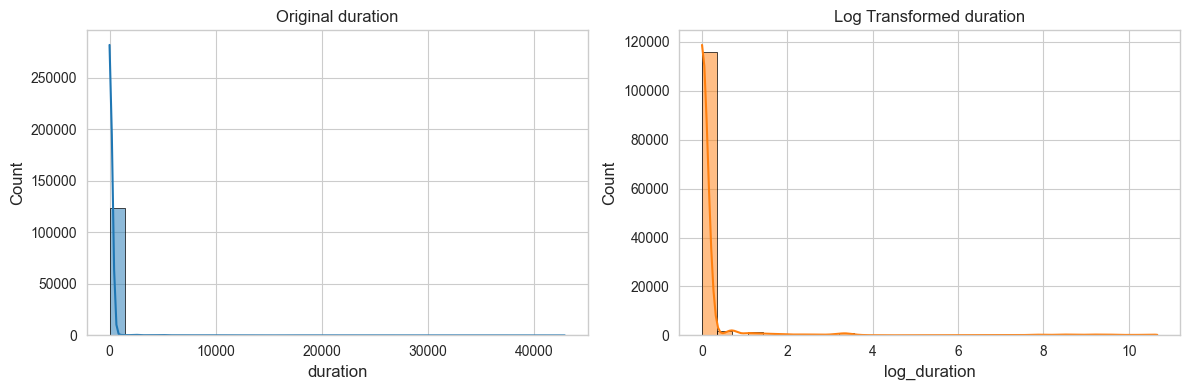

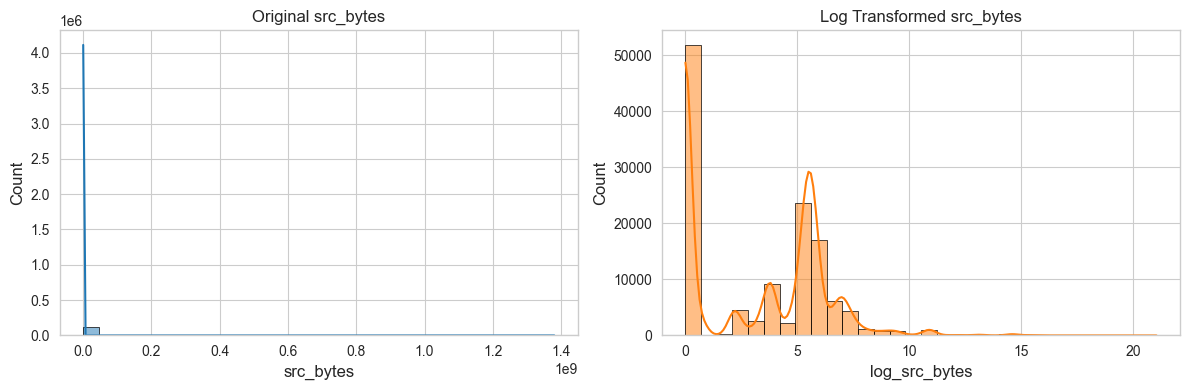

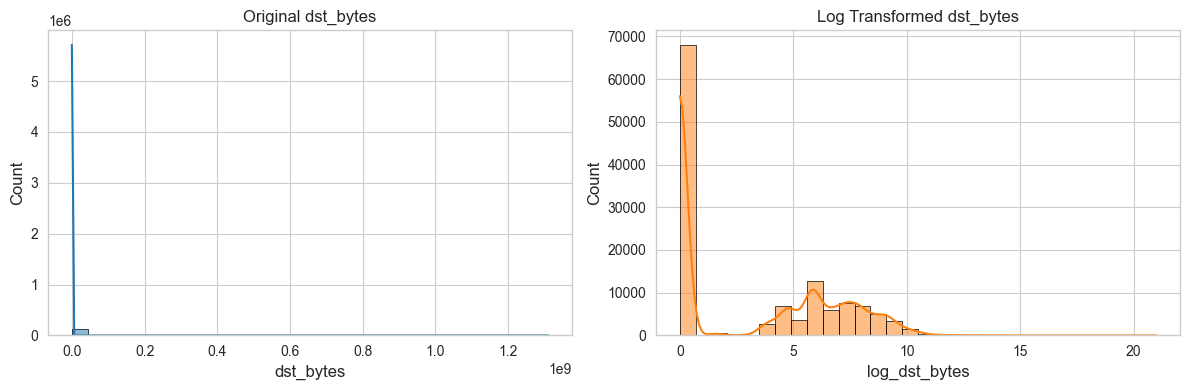

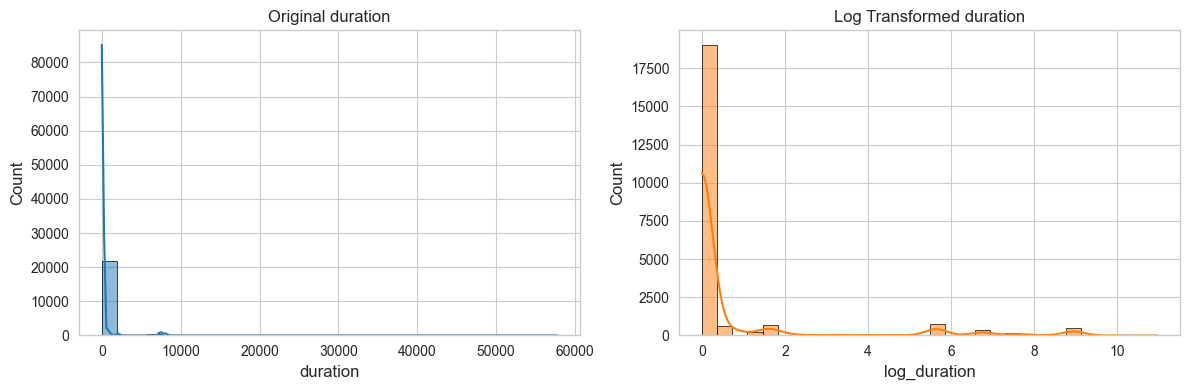

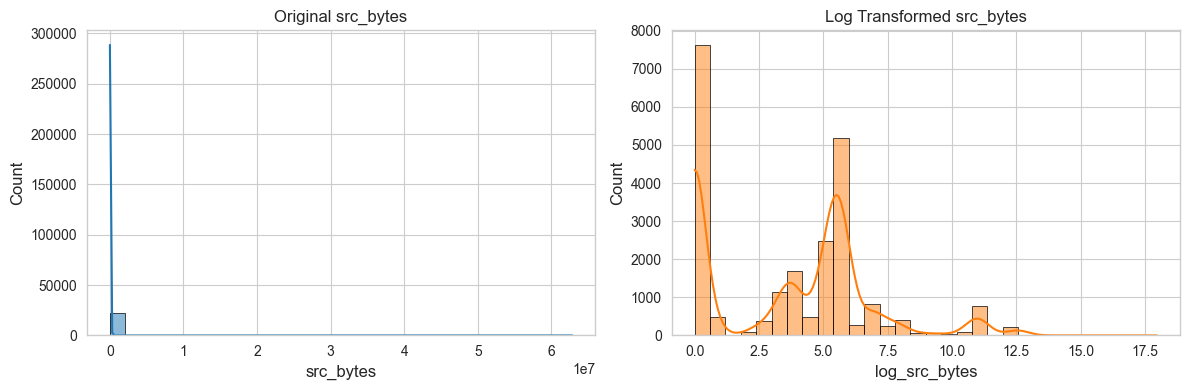

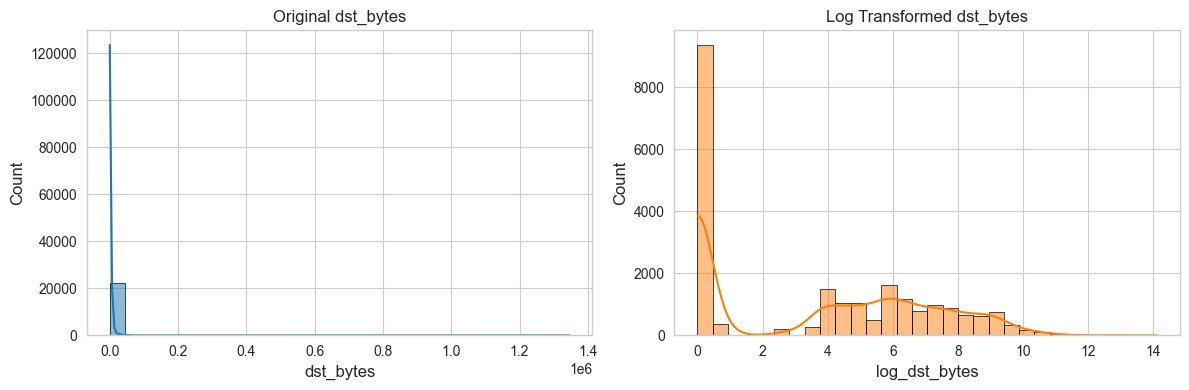

In [8]:

skewed_cols = ['duration','src_bytes','dst_bytes']

def apply_log_transform(df, cols):
    df_transform = df.copy()

    # Set style
    sns.set_style("whitegrid")

    for col in cols:
        new_col = f"log_{col}"
        df_transform[new_col] = np.log1p(df_transform[col])

        plt.figure(figsize=(12,4))

        # Original Distribution
        plt.subplot(1,2,1)
        sns.histplot(
            df[col],
            bins=30,
            kde=True,
            color="#1f77b4",   # Blue
            edgecolor="black"
        )
        plt.title(f"Original {col}", fontsize=12)

        # Transformed Distribution
        plt.subplot(1,2,2)
        sns.histplot(
            df_transform[new_col],
            bins=30,
            kde=True,
            color="#ff7f0e",   # Orange
            edgecolor="black"
        )
        plt.title(f"Log Transformed {col}", fontsize=12)

        plt.tight_layout()
        plt.show()

    return df_transform

df_train = apply_log_transform(df_train, skewed_cols)
df_test = apply_log_transform(df_test, skewed_cols)

In [10]:
skewed_cols = ['duration','src_bytes','dst_bytes']

def apply_log_transform(df, cols):
    df_transform = df.copy()

    for col in cols:
        df_transform[f"log_{col}"] = np.log1p(df_transform[col])

    return df_transform

df_train = apply_log_transform(df_train, skewed_cols)
df_test = apply_log_transform(df_test, skewed_cols)

In [11]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level,attack_class,is_outlier,log_duration,log_src_bytes,log_dst_bytes
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.05,0.00,normal,20,normal,1,0.0,6.198479,0.000000
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,normal,15,normal,1,0.0,4.990433,0.000000
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,neptune,19,DoS,1,0.0,0.000000,0.000000
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.01,0.00,0.01,normal,21,normal,1,0.0,5.451038,9.006264
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,normal,21,normal,1,0.0,5.298317,6.042633


In [12]:
df_train.to_csv("df_train_log_transformed.csv", index=False)
df_test.to_csv("df_test_log_transformed.csv", index=False)

print("CSV files saved successfully ")

CSV files saved successfully 


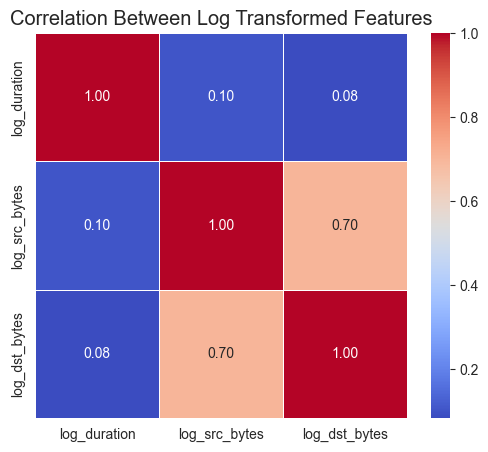

In [13]:
log_cols = [f"log_{col}" for col in skewed_cols]

corr_matrix = df_train[log_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Between Log Transformed Features")
plt.show()

In [14]:
def engineer_features(df):
    df_eng = df.copy()
    
    # 1. Total Bytes
    df_eng['total_bytes'] = df_eng['src_bytes'] + df_eng['dst_bytes']
    
    # 2. Byte Ratio (Handle division by zero)
    df_eng['src_bytes_ratio'] = df_eng['src_bytes'] / (df_eng['total_bytes'] + 1e-5)
    
    # 3. Load / Packet Rate
    # If duration is 0, we assume it's a single instantaneous event (rate = count)
    df_eng['packet_rate'] = df_eng['count'] / (df_eng['duration'] + 1e-5)
    
    # 4. Title: Flow Asymmetry
    df_eng['byte_diff'] = abs(df_eng['src_bytes'] - df_eng['dst_bytes'])
    
    # 5. Flag interactions (example: is it an error flag?)
    error_flags = ['S0', 'S1', 'S2', 'S3', 'REJ']
    df_eng['is_error_flag'] = df_eng['flag'].isin(error_flags).astype(int)
    
    # 6. Critical Host Interaction
    # Interaction between 'same_srv_rate' and 'dst_host_same_srv_rate'
    df_eng['same_srv_interaction'] = df_eng['same_srv_rate'] * df_eng['dst_host_same_srv_rate']
    
    return df_eng

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

print("New Feature Set Head:")
print(df_train[['src_bytes_ratio', 'packet_rate', 'is_error_flag', 'same_srv_interaction']].head())

New Feature Set Head:
   src_bytes_ratio  packet_rate  is_error_flag  same_srv_interaction
0         1.000000     200000.0              0                 0.170
1         1.000000    1300000.0              0                 0.000
2         0.000000   12300000.0              1                 0.005
3         0.027668     500000.0              0                 1.000
4         0.321486    3000000.0              0                 1.000


In [15]:
df_train['service']

0         ftp_data
1            other
2          private
3             http
4             http
            ...   
125968     private
125969     private
125970        smtp
125971      klogin
125972    ftp_data
Name: service, Length: 125973, dtype: object

In [16]:
ohe = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
cols_to_encode = ['protocol_type','flag']

#Fit and Train

ohe_train = pd.DataFrame(ohe.fit_transform(df_train[cols_to_encode]))
ohe_train.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_train.index = df_train.index
# ohe_train.index

#Transform Test

ohe_test = pd.DataFrame(ohe.transform(df_test[cols_to_encode]))
ohe_test.columns = ohe.get_feature_names_out(cols_to_encode)
ohe_test.index = df_test.index

service_freq = df_train['service'].value_counts(normalize = True)
df_train['service_freq'] = df_train['service'].map(service_freq)
df_test['service_freq'] = df_test['service'].map(service_freq).fillna(0)

df_train_encode = pd.concat([df_train,ohe_train],axis = 1)
df_test_encode = pd.concat([df_test,ohe_test],axis = 1)

df_train_encode.columns
# df_train_encode

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'log_duration', 'log_src_bytes', 'log_dst_bytes',
       'total_bytes', 'src_bytes_ratio', 'packet_rate', 'byte_dif

In [17]:
print(df_train_encode.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level', 'attack_class',
       'is_outlier', 'log_duration', 'log_src_bytes', 'log_dst_bytes',
       'total_bytes', 'src_bytes_ratio', 'packet_rate', 'byte_dif

In [18]:
df_test_encode

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,tcp,http,SF,317,938,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
df_train_encode.drop(columns=['protocol_type','flag','service'],inplace = True)
df_test_encode.drop(columns=['protocol_type','flag','service'],inplace = True)

In [20]:
print(df_train_encode.shape)

df_test_encode

(125973, 66)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


REMOVAL OF NOISE 

In [21]:
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

In [22]:
constant_cols = [col for col in df_train.columns 
                 if df_train[col].nunique() <= 1]

df_train = df_train.drop(columns=constant_cols)
df_test = df_test.drop(columns=constant_cols)

print("Removed constant columns:", constant_cols)

Removed constant columns: ['num_outbound_cmds']


In [23]:
numeric_df = df_train.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
protected_features = [
    'packet_rate',
    'byte_diff',
    'same_srv_interaction'
]

high_corr_cols = [
    col for col in upper.columns
    if any(upper[col] > 0.95)
    and col not in protected_features
]

df_train = df_train.drop(columns=high_corr_cols)
df_test = df_test.drop(columns=high_corr_cols)

print("Removed highly correlated columns:", high_corr_cols)
print("Protected engineered features kept:", protected_features)

Removed highly correlated columns: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']
Protected engineered features kept: ['packet_rate', 'byte_diff', 'same_srv_interaction']


In [24]:
X = df_train.drop('label', axis=1)
y = df_train['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [25]:
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

In [26]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X, y)
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7485361958836054
[[  0 447   0 ...   0   0   0]
 [  0 359   0 ...   0   0   0]
 [  0   0   5 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   7 ...   0   0   0]]
                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.45      1.00      0.62       359
buffer_overflow       0.33      0.25      0.29        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       1.00      0.30      0.46      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.37      0.98      0.54       141
           land       1.00      0.86      0.92         7
     loadmodule       0.25      0.50      0.33         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00 

In [28]:
X = pd.get_dummies(X, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)

if 'flag_S0' in X.columns:
    X = X.drop(columns=['flag_S0'])
    X_test = X_test.drop(columns=['flag_S0'], errors='ignore')

print("flag_S0 removed after encoding")

flag_S0 removed after encoding


In [36]:
from sklearn.preprocessing import RobustScaler

exclude_cols = ['label','attack_class','difficulty_level','is_outlier']

numeric_cols = df_train.select_dtypes(include=['int64','float64']).columns
features_to_scale = [
    col for col in numeric_cols
    if col not in exclude_cols
]
scaler = RobustScaler()
df_train[features_to_scale] = scaler.fit_transform(
    df_train[features_to_scale]
)

df_test[features_to_scale] = scaler.transform(
    df_test[features_to_scale]
)

print(df_train[features_to_scale[:5]].describe())

           duration     src_bytes     dst_bytes           land  wrong_fragment
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000   125973.000000
mean      287.14465  1.649375e+02  3.833162e+01       0.000198        0.022687
std      2604.51531  2.126932e+04  7.793157e+03       0.014086        0.253530
min         0.00000 -1.594203e-01  0.000000e+00       0.000000        0.000000
25%         0.00000 -1.594203e-01  0.000000e+00       0.000000        0.000000
50%         0.00000  0.000000e+00  0.000000e+00       0.000000        0.000000
75%         0.00000  8.405797e-01  1.000000e+00       0.000000        0.000000
max     42908.00000  4.999869e+06  2.538638e+06       1.000000        3.000000


In [38]:
df_train[features_to_scale[0:5]]

,duration,src_bytes,dst_bytes,land,wrong_fragment
0,0.0,1.619565,0.000000,0.0,0.0
1,0.0,0.369565,0.000000,0.0,0.0
2,0.0,-0.159420,0.000000,0.0,0.0
3,0.0,0.681159,15.800388,0.0,0.0
4,0.0,0.561594,0.813953,0.0,0.0
...,...,...,...,...,...
125968,0.0,-0.159420,0.000000,0.0,0.0
125969,8.0,0.221014,0.281008,0.0,0.0
125970,0.0,7.923913,0.744186,0.0,0.0
125971,0.0,-0.159420,0.000000,0.0,0.0


In [40]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/2 [sklearn-compat]
   ---------------------------------------- 0/2 [sklearn-compat]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbal

In [45]:
from imblearn.over_sampling import SMOTE

target_col = 'attack_class'

y = df_train[target_col]

X = df_train.drop(
    columns=['label', 'attack_class', 'difficulty_level']
)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)

print("Before SMOTE:")
print(y.value_counts())
smote = SMOTE(k_neighbors=3, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nAfter SMOTE:")
print(y_resampled.value_counts())

Before SMOTE:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

After SMOTE:
attack_class
normal    67343
DoS       67343
R2L       67343
Probe     67343
U2R       67343
Name: count, dtype: int64


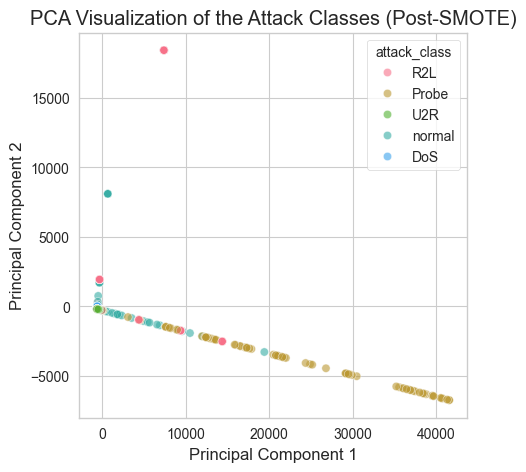

In [46]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_resampled.sample(5000,random_state = 42))

plt.figure(figsize = (5,5))
sns.scatterplot(x = x_pca[:,0], y = x_pca[:,1],hue = y_resampled.sample(5000,random_state = 42),alpha = 0.6)
plt.title("PCA Visualization of the Attack Classes (Post-SMOTE)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [47]:
import os
df_final_train = pd.concat([X_resampled,y_resampled],axis=1)
output_dir = '..SentinelNet/data/processed/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
save_path = os.path.join(output_dir, 'train_processed_advanced.csv')
df_final_train.to_csv(save_path,index = False)
print(f"Saved the Data to {save_path}")

Saved the Data to ..SentinelNet/data/processed/train_processed_advanced.csv
